# CM50268 :: Final project (group work)

**Total Marks 25 (25% of overall unit grade).** 

*Submission deadline: 8pm, May 10, 2022. Please submit this file along with your individual report in Moodle*

## Submission & Marking

This group exercise is assessed, and the marks will contribute to your final grade. For this exercise there are a number of places where you are expected to enter your own code. Please see the BML Final Project Specification document for details. 

Every place you have to add code is described in the text and specifically indicated by the comment:

`#### **** YOUR CODE HERE **** ####`


**Please submit your completed workbook using Moodle before 8pm on May 10, 2022 along with your individual report**. The workbook you submit must be this `.ipynb` file, which is saved into the directory you're running Jupyter; alternatively you can download it from the menu above using `File -> Download As -> Notebook (.ipynb)`. Remember to save your work regularly (Save and Checkpoint in the File menu, the icon of a floppy disk, or Ctrl-S); the version you submit should have all code blocks showing the results (if any) of execution below them.

**You should take care to avoid any suggestion of plagiarism in your submission.** There is helpful information on how to avoid plagiarism on the University website: http://www.bath.ac.uk/library/help/infoguides/plagiarism.html

# Project setup

This coursework involves the evaluation of Bayesian modelling methods on a real multivariate regression task. Please check the pdf file for the details of the project.

- <font color=Red> Please try to use fixed random seeds to make your results reproducible </font>

- <font color=Red> Please do NOT change the name of the fixed variables, as Task 2 - Task 5 of this coding exercises are auto-marked </font>

The marks for Task 1 and Task 6 will be awarded based only on the content of the report.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

import hmc_Lab as hmc

# Task 1 : Exploratory analysis (Section 4.1 in the specification doc)

Undertake an initial exploratory analysis of the training data and summarise. Code in Task 1 will NOT by auto-marked. Results of Task 1 will be assessed along with your individual report, i.e., 4 marks in total. 

 - <font color=Red> Please perserve the variables `X_train` and  `y_train` representing the normalised data in numpy array, as required for the following exercises  </font>

 - `X_train` is an np.array with shape (384, 9). The 1st column is a constant (bias) $x_0$ and the 2nd to the 9th columns are data variables $x_1,x_2,\dots,x_8$

 - `y_train` is also an np.array with shape (384,), representing the target variable $y$ 

In [10]:
from sklearn.preprocessing import StandardScaler

np.set_printoptions(suppress=True)

dataset = pd.read_csv('ee-train.csv').values

y_train = dataset[:,-1]

X_train = dataset[:,:-1]

standardiser = StandardScaler()


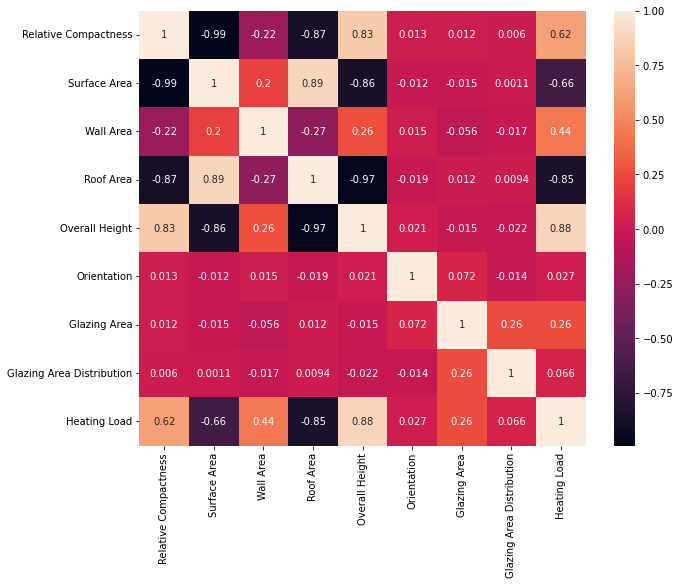

In [11]:
import seaborn as sn
pd_x = pd.DataFrame(dataset[:,1:],columns =['Relative Compactness','Surface Area','Wall Area','Roof Area','Overall Height','Orientation','Glazing Area','Glazing Area Distribution','Heating Load'])
import matplotlib.pyplot as plt
plt.figure(figsize = [10,8])
sn.heatmap(pd_x.corr(), annot=True)
plt.show()

In [12]:
# Check whether fixed variables are correctly defined ..
try:
    if not isinstance(X_train,np.ndarray):
        print('X_train should be an array')        
    if X_train.shape != (384,9):
        print('X_train is arranged in wrong shape')
except Exception as err:
    print('Error output:', err)
    
try:
    if not isinstance(y_train,np.ndarray):
        print('y_train should be an array')        
    if y_train.shape != (384,):
        print('y_train is arranged in wrong shape')
except Exception as err:
    print('Error output:', err)

In [13]:
test = pd.read_csv('ee-test.csv').values
X_test = test[:,:-1]
y_test = test[:,-1]

In [14]:
#Linear-Model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


baseline_model = LinearRegression(fit_intercept=False).fit(X_train,y_train)
pred_base_test = baseline_model.predict(X_test)
pred_base_train = baseline_model.predict(X_train)

train_linear_rmse = mean_squared_error(y_train, pred_base_train, squared=False)
test_linear_rmse = mean_squared_error(y_test, pred_base_test, squared=False)

print('RMSE for Training -',train_linear_rmse)
print('RMSE for Testing -',test_linear_rmse)

RMSE for Training - 3.011551787650361
RMSE for Testing - 2.8435880167333187


In [15]:
X_test = standardiser.fit_transform(X_test)

X_train = standardiser.fit_transform(X_train)

for i,cont in enumerate(X_train):
    X_train[i][0] = 1

for i,cont in enumerate(X_test):
    X_test[i][0] = 1   

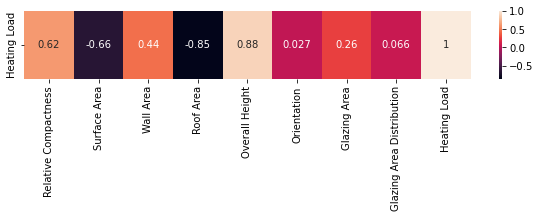

In [16]:
col = ['Relative Compactness','Surface Area','Wall Area','Roof Area','Overall Height','Orientation','Glazing Area','Glazing Area Distribution']
plt.figure(figsize = [10,1.25])
sn.heatmap((pd_x.corr()).tail(1), annot=True)
plt.show()

#  Task 2 : Type-2 maximum likelihood (Section 4.2 (a) in the specification doc)

###  **(6 marks)**

Precisions are defined as: $\alpha = 1 / \sigma_w^2$ and $ \beta = 1 / \sigma_{\epsilon}^2 $

Assume priors of $\alpha$ and $\beta$ follow flat Uniform distributions, please derive a likelihood function $(y|\alpha, \beta)$ (`compute_log_marginal`) to compute the *log-ikelihood* for the Bayesian linear regression problem using $X$ and hyperparameters $\alpha$ and $\beta$. 

In Lecture 4, slide 11 and 12 we have illustrated the equations of finding the most probable hyperparameters to maximise the likelihood with respect to the hyperparameters (slide 12).


`X`: this is an np.array equivalent to matrix $X$ in the specification doc, e.g., `X_train`, `X_test`.

`y`: this is an np.array equivalent totarget $y$ in the specification doc, e.g., `y_train`, `y_test`.


In [17]:
def compute_log_marginal(X, y, alpha, beta):
    s2 = 1/beta
    lgp = stats.multivariate_normal.logpdf(y, mean=np.zeros(np.shape(y)[0]), 
    cov=s2 * np.identity(X.shape[0]) + (X @ X.T) * 1/alpha, allow_singular=True)
    return lgp

Compute log-evidence (marginal likelihood) `log_prob_y` and plot the 'contourf' of the log-posterior distribution.

- The x-axis should be the value of $log \alpha$ and y-axis the $log\beta$, `log_prob_y` represents the log-evidence. For each axis, it is recommended to use 
`np.linspace(-5,0,100)`

- It is strongly recommended that you use only natural logarithms for hyper-parameter scales. That is, you would use `numpy.exp()` and `numpy.log()` functions to convert (or to convert back) the logarithm terms.

In [18]:
log_alpha = np.linspace(-5,0,100)

log_beta = np.linspace(-5,0,100)

log_prob_y = np.empty([100,100])

for row,a in enumerate(log_alpha):
    for col,b in enumerate(log_beta):
        log_prob_y[col][row] = compute_log_marginal(X_train,y_train, np.exp(a),np.exp(b))

# Check whether your variables are correctly defined ..
try:
    if not isinstance(log_prob_y,np.ndarray):
        print('log_prob_y should be an array')        
    if log_prob_y.shape != (100,100):
        print('log_prob_y is arranged in a wrong shape')
except Exception as err:
    print('Error output:', err)

Print out the most proboble values of the parameters $\alpha$ and $\beta$ and the corresponding log-likelihood value.

In [19]:
#### **** YOUR CODE HERE **** ####
log_prob_y = np.array(log_prob_y)

local = np.where(log_prob_y == log_prob_y.max())

max_alpha = log_alpha[local[1][0]]

max_beta = log_beta[local[0][0]]

print('Most Probable Alpha -',np.exp(max_alpha))

print('Most Probable Beta -',np.exp(max_beta))

print('Log Likelihood:',log_prob_y.max())

Most Probable Alpha - 0.01174362845702136
Most Probable Beta - 0.10836802322189586
Log Likelihood: -1001.4576252255189


Visualisation using `plt.contourf`for the posterior distribution and indicate the most probable value (with a highlighted marker) in the graph.

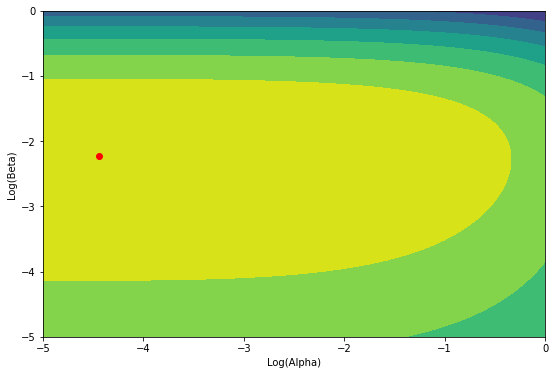

In [12]:
plt.figure(figsize=(9, 6))
plt.contourf(log_alpha, log_beta, log_prob_y)
plt.scatter(max_alpha,max_beta,color = 'red')
plt.ylabel('Log(Beta)')
plt.xlabel('Log(Alpha)')
plt.show()

Write a function `compute_posterior(X, y, alph, beta)`  to compute the posterior mean $\mathbf{\mu}$ (`Mu`) and covariance $\mathbf{\Sigma}$ (`SIGMA`) for the Bayesian linear regression model, and return `Mu` and `SIGMA` for the posterior in the np.array format. 

In [13]:
def compute_posterior(X, y, alpha, beta):  
    SIGMA = np.linalg.inv(beta*(X.T @ X) + alpha*np.identity(X.shape[1]))
    Mu = beta * (np.linalg.inv(beta*(X.T @ X) + alpha*np.identity(X.shape[1])) @ (X.T @ y))
    return Mu, SIGMA

Calculate the predicted weights and print out the corresponding RMSE for training and test sets.

In [14]:
from sklearn.metrics import mean_squared_error

Mu,SIGMA = compute_posterior(X_train, y_train,np.exp(max_alpha),np.exp(max_beta))

pred_train = X_train @ Mu
pred_test = X_test @ Mu

rmse_type2_train = mean_squared_error(y_train, pred_train, squared=False) # squared = False sets RMSE
rmse_type2_test = mean_squared_error(y_test,pred_test, squared=False)

print('RSME for Training -',rmse_type2_train)
print('RSME for Testing -',rmse_type2_test)

RSME for Training - 3.0116945897528127
RSME for Testing - 3.0925828136429194


# Task 3: Variational Inference (Section 4.2 (b) in the specification doc)

###  **(4 marks)**

Write a Variational Inference function `VI(X_train, Y_train)` and return parameter estimates. 

The returned terms should include:

`an`, `bn`, `cn`, `dn`: float

`mn_n`: np.array, shape = (9,),

`sig_n`: np.array, shape = (9,9),

where

`an` and `bn` are the hyper-parameters for $w\propto  N(w|0,\alpha)$,  $\alpha\propto Gamma(\alpha|a,b) $. 

`cn` and `dn` are the hyper-parameters for gaussian noise $N(0,\beta)$,  $\beta\propto Gamma(\beta|c,d) $.

`mn_n` and `sig_n` are the mean $\mathbf{\mu}$ and covariance $\mathbf{\Sigma}$ of the posterior distribution w.r.t. $w$ (in this task) for the Bayesian linear regression model.

The corresponding derivations should be completed in your report.



In [24]:
Y_train = y_train.copy()

def compute_posterior_(X_train,Y_train,alpha,beta):
    sig_n = np.linalg.inv(beta*(X_train.T @ X_train) + (alpha)*np.identity(X_train.shape[1]))
    mu_n = (sig_n @ (X_train.T @ (beta * Y_train)))
    return sig_n, mu_n

def VI(X_train, Y_train):
    a0,b0,c0,d0 = 0.0001,0.0001,0.0001,0.0001
    alpha = a0/b0
    beta = c0/d0
    for row in range(X_train.shape[0]):
        # Update Posterior Distirbution - mu and sigma
        sig_n,mu_n = compute_posterior_(X_train,Y_train,alpha,beta)
        # Update Alpha - an and bn
        an = a0 + X_train.shape[1]/2
        bn = b0 + 1/2*((mu_n.T @ mu_n) + np.trace(sig_n))
        # Update Beta - cn and dn
        cn = c0 + Y_train.shape[0]/2
        dn = d0 + (((X_train @ mu_n)-Y_train).T @ ((X_train @ mu_n)-Y_train)) / 2
        # Update Alpha Beta
        alpha = an/bn
        beta = cn/dn
    return an,bn,cn,dn, mu_n, sig_n


Print out the expectation of $\alpha$ and $\beta$ as `exp_alpha`,`exp_beta`. 


In [202]:
try:
    an,bn,cn,dn, mu_n, sig_n = VI(X_train, Y_train)
except Exception as err:
    print('Error output:', err)

exp_alpha = an/bn
exp_beta = cn/dn

print('Expected Alpha -', exp_alpha)
print('Expected Beta-', exp_beta)

Expected Alpha - 0.01192439250898537
Expected Beta- 0.11024997373399267


In [203]:
# Check whether your variables are correctly defined  ..
try:
    if not isinstance(mu_n,np.ndarray):
        print('mu_n should be an array')        
    if mu_n.shape != (9,):
        print('mu_n is arranged in wrong shape')
except Exception as err:
    print('Error output:', err)
    
try:
    if not isinstance(sig_n,np.ndarray):
        print('sig_n should be an array')        
    if sig_n.shape != (9,9):
        print('sig_n is arranged in wrong shape')
except Exception as err:
    print('Error output:', err)
    
try:
    exp_alpha
    exp_beta
except Exception as err:
    print('Error output:', err)

Calculate the RMSE for training and test sets.

In [204]:
#### **** YOUR CODE HERE **** ####
from sklearn.metrics import mean_squared_error
pred_train = X_train @ mu_n
pred_test = X_test @ mu_n


rmse_train = mean_squared_error(y_train, pred_train, squared=False) # squared = False sets RMSE
rmse_test = mean_squared_error(y_test,pred_test, squared=False)

print('RSME for Training -',rmse_train)
print('RSME for Testing -',rmse_test)

RSME for Training - 3.0116940662643006
RSME for Testing - 3.092588870671393


Extra Figures

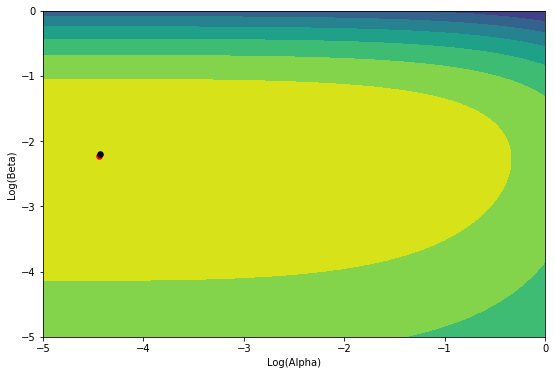

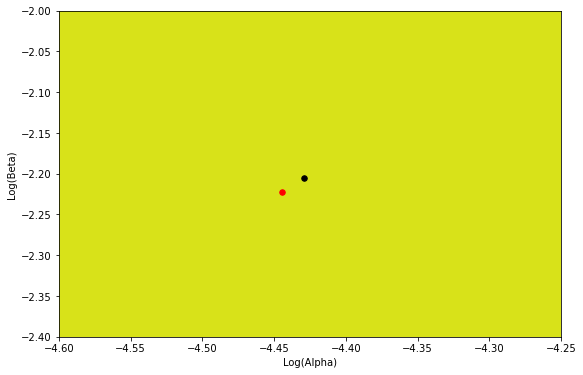

In [205]:
plt.figure(figsize=(9, 6))
plt.contourf(log_alpha, log_beta, log_prob_y)
plt.scatter(max_alpha,max_beta,s=30,color = 'red')
plt.scatter(np.log(exp_alpha),np.log(exp_beta),s=30,color = 'black')
plt.ylabel('Log(Beta)')
plt.xlabel('Log(Alpha)')
plt.show()

plt.figure(figsize=(9, 6)) 
plt.contourf(log_alpha, log_beta, log_prob_y)
plt.scatter(max_alpha,max_beta,s=30,color = 'red')
plt.scatter(np.log(exp_alpha),np.log(exp_beta),s=30,color = 'black')
plt.axis([-4.6, -4.25, -2.4, -2.0])
plt.ylabel('Log(Beta)')
plt.xlabel('Log(Alpha)')
plt.show()


# Task 4: Verify HMC on a standard 2D Gaussian example (Section 4.3 in the specification doc)

###  **(4 marks)**

## The "Distribution"

Complete the following functions:

- `energy_func(x)`: the energy function, return negative log pdf value in float format
- `energy_grad(x)`: the gradient function returns a numpy array containing the partial derivatives of the energy function with respect to the parameters/hyper-parameters.
- `covar`: Covariance matrix for 2-dimensional gaussian. It is an numpy array with shape (2,2), e.g,  np.array([[1.0875,1],[1,1.0875]]) 

- `R`: the number of samples desired
- `L`: number of simulation steps; for this simple case, 20 is easily enough
- `eps`: simulation step length; set by trial-and-error to give approx. 90% acceptance
- `burn`: simply set to `R/10`
- `checkgrad`: set to true to test the consistency of `energy_func` and `energy_grad`



In [206]:
def energy_func(x, covar):
    neglgp = -stats.multivariate_normal.logpdf(x = x, cov = covar)
    return neglgp

def energy_grad(x, covar):
    #initialise array
    g = np.empty(2)
    #calc p
    p = (covar[0][1])/(((covar[0][0])*(covar[1][1])))
    # d/da
    g[0] = (x[0] - x[1]*p)/(1-p**2)
    # d/db
    g[1] = (x[1] - x[0]*p)/(1-p**2)
    return g

## Visualising the Distribution
Before we run the sampler, let's visualise the distribution over an appropriate
grid of values. Please specify `covar` to plot figures, an naive example of `covar` has been shown below

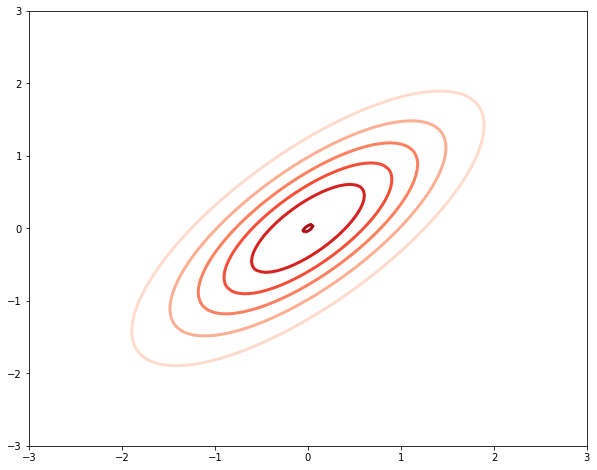

In [207]:
import numpy as np

covar = np.array([[1,0.75],[0.75,1]]) 

# Other plotting parameters
fsz = (10,8)
gsz = 100
lim = 3

# Setup the mesh grid

gx = np.linspace(-lim, lim, gsz)
GX, GY = np.meshgrid(gx, gx)
Gsz = GX.size
G = np.hstack((GX.reshape((Gsz, 1)), GY.reshape((Gsz, 1))))

# Plot the figure
plt.figure(figsize=fsz)
P = np.asarray([np.exp(-energy_func(g, covar)) for g in G])
plt.contour(GX, GY, P.reshape((gsz, gsz)), cmap='Reds', linewidths=3, zorder=1);



In [208]:
try:
    if not isinstance(covar ,np.ndarray):
        print('covar  should be an array')        
    if covar .shape != (2,2):
        print('covar  is arranged in wrong shape')
except Exception as err:
    print('Error output:', err)

In [209]:
# Initialise the state for the first time step
x0 = np.random.normal(size=2)

# Call the function from the pre-defined hmc module
hmc.gradient_check(x0, energy_func, energy_grad, covar)

Calc.         Numeric       Delta         Acc.
    -3.02643      -3.02643   4.903322e-11  11
     1.85227       1.85227  -2.461842e-10  10


## Hyper-parameters

Please tune optimal hyper-parameters incluidng `R`, `L`, and `eps` in the cell below. 

Calc.         Numeric       Delta         Acc.
    -3.02643      -3.02643   4.903322e-11  11
     1.85227       1.85227  -2.461842e-10  10
|----------|  0% accepted [ 4 secs to go ]
|#---------| 80% accepted [ 4 secs to go ]
|##--------| 81% accepted [ 4 secs to go ]
|###-------| 80% accepted [ 3 secs to go ]
|####------| 80% accepted [ 3 secs to go ]
|#####-----| 80% accepted [ 2 secs to go ]
|######----| 80% accepted [ 2 secs to go ]
|#######---| 80% accepted [ 1 secs to go ]
|########--| 80% accepted [ 1 secs to go ]
|#########-| 80% accepted [ 0 secs to go ]
|##########| 80% accepted [ 0 secs to go ]
HMC: R=10000 / L=25 / eps=0.77 / Accept=80.0%


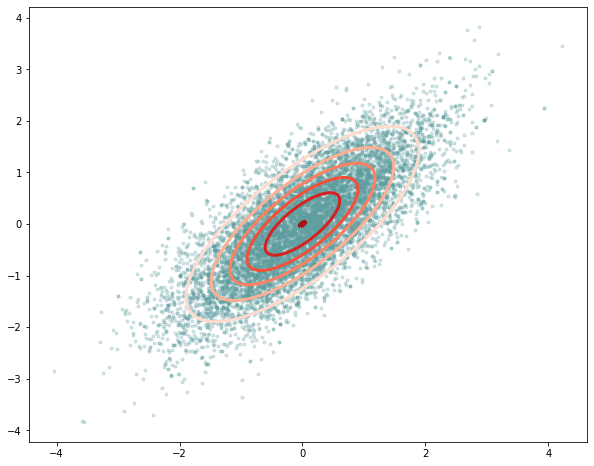

In [210]:
np.random.seed(seed=1)  # Fix the random seed for better reproducibility

R= 10000
L = 25
eps = 0.77
burn = int(R/10) 
# HMC sampling
S, *_ = hmc.sample(x0, energy_func, energy_grad, R, L, eps, burn=burn, checkgrad=True, args=[covar])
# Plot the figure
plt.figure(figsize=fsz)
plt.plot(S[:, 0], S[:, 1], '.', ms=6, color='CadetBlue', alpha=0.25, zorder=0)
plt.contour(GX, GY, P.reshape((gsz, gsz)), cmap='Reds', linewidths=3, zorder=1);

Calc.         Numeric       Delta         Acc.
    -3.02643      -3.02643   4.903322e-11  11
     1.85227       1.85227  -2.461842e-10  10
|----------|  0% accepted [ 4 secs to go ]
|#---------| 94% accepted [ 4 secs to go ]
|##--------| 94% accepted [ 3 secs to go ]
|###-------| 94% accepted [ 3 secs to go ]
|####------| 94% accepted [ 3 secs to go ]
|#####-----| 94% accepted [ 2 secs to go ]
|######----| 94% accepted [ 2 secs to go ]
|#######---| 94% accepted [ 1 secs to go ]
|########--| 94% accepted [ 1 secs to go ]
|#########-| 94% accepted [ 0 secs to go ]
|##########| 94% accepted [ 0 secs to go ]
HMC: R=10000 / L=25 / eps=0.5 / Accept=93.9%
Calc.         Numeric       Delta         Acc.
    -3.02643      -3.02643   4.903322e-11  11
     1.85227       1.85227  -2.461842e-10  10
|----------|  0% accepted [ 4 secs to go ]
|#---------| 86% accepted [ 4 secs to go ]
|##--------| 85% accepted [ 3 secs to go ]
|###-------| 85% accepted [ 3 secs to go ]
|####------| 86% accepted [ 2 se

,25,50,100,150
0.73,83.13,83.36,83.31,83.61
0.74,83.08,83.10,83.35,82.48
0.75,81.68,82.19,82.00,81.93
0.76,81.19,81.41,81.24,80.99
0.77,79.68,80.42,80.01,80.43
0.78,79.37,79.17,78.72,79.60
0.79,78.82,78.67,77.36,77.91
0.80,77.27,77.01,76.40,76.77


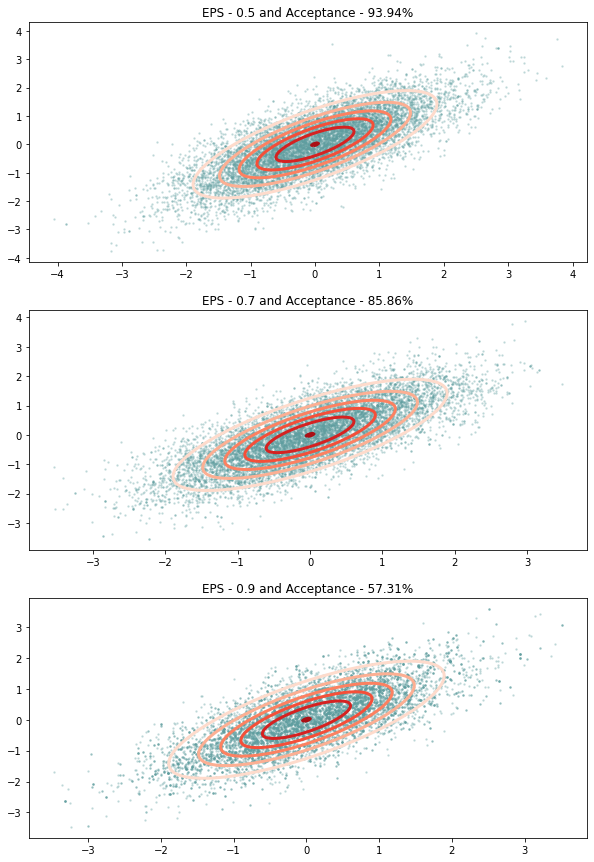

In [211]:
#### **** YOUR CODE HERE **** ####

#### **** You can add extra figures to support the individual report **** ####
 
np.random.seed(seed=1)  # Fix the random seed for better reproducibility

fig, ax = plt.subplots(3, 1, figsize = [10,15])

count = 0

for ep in [0.5,0.7,0.9]:
    R_test= 10000
    L_test = 25
    eps_test = ep
    burn_test = int(R/10) 
    # HMC sampling
    S, Reject = hmc.sample(x0, energy_func, energy_grad, R_test, L_test, eps_test, burn=burn_test, checkgrad=True, args=[covar])
    # Plot the figure
    title = str("EPS - "  + str(ep) + " and Acceptance - " + str(round(((R_test-Reject)/R_test*100),5)) + "%")
    ax[count].title.set_text(title)
    ax[count].plot(S[:, 0], S[:, 1], '.', ms=3, color='CadetBlue', alpha=0.25, zorder=0)
    ax[count].contour(GX, GY, P.reshape((gsz, gsz)), cmap='Reds', linewidths=3, zorder=1);
    count += 1

results_4_to_5 = []
for ep in [0.73,0.74,0.75,0.76,0.77,0.78,0.79,0.80]:
    ep_iter = []
    for l_ in [25,50,100,150]:
        R_test= 10000
        L_test = 25
        eps_test = ep
        burn = int(R/10) 
        # HMC sampling
        S, Reject = hmc.sample(x0, energy_func, energy_grad, R_test, L_test, eps_test, burn=burn_test, checkgrad=True, args=[covar])
        accept = round(((R_test-Reject)/R_test*100),5)
        ep_iter.append(accept)
    results_4_to_5.append(ep_iter)

pd.DataFrame(results_4_to_5, columns=[25,50,100,150], index =[0.73,0.74,0.75,0.76,0.77,0.78,0.79,0.80])

# Task 5: Apply HMC to the Linear Regression Model (Section 4.4 in the specification doc)

###  **(8 marks)**

Complete the functions and the HMC code for this task:

- `energy_func_lr(hps, x, y)`: where `hps` is a 2+9 dimension array, where the 1st dimension represents $\alpha$, and the 2nd represnets $\beta$. Thus, `hps[0]` should be the current $\alpha$, `hps[1]` the $\beta$ and `hps[2:]` represent the weights `w` for constant and 8 variables respectively. `x` and `y` is the x and y array of training data.

- `energy_grad_lr(hps, x, y)`: the gradient function returns an array containing the partial derivatives of the energy function. should be the same shape for hps. 

- `R`: the number of samples desired
- `L`: number of simulation steps; for this simple case, 20 is easily enough
- `eps`: simulation step length; set by trial-and-error to give approx. 90% acceptance
- `burn`: simply set to `R/10`
- `checkgrad`: set to true to test the consistency of `energy_func` and `energy_grad`




In [25]:
def energy_func_lr(hps, x, y):
    alpha = hps[0]
    beta = hps[1]
    w = hps[2:]
    
    log_likelihood = (1/2) * (x.shape[0] * np.log(np.exp(beta)/(2)) - (y - x @ w).T @ (y - x @ w) * np.exp(beta))
    log_prior = (1/2) * (x.shape[1] * np.log(np.exp(alpha)/(2)) - (w.T @ w)*np.exp(alpha))
    neglgp = -(log_likelihood + log_prior)    
    return neglgp

In [26]:
def energy_grad_lr(hps, x, y):
    g = np.empty(11)
    alpha = hps[0]
    beta = hps[1]
    w = hps[2:]
    
    # Alpha Partial
    g[0] = (1/2)*(np.exp(alpha)* w @ w.T - x.shape[1])
    # Beta Partial 
    g[1] = (1/2)*(np.exp(beta)*sum((y - x @ w)**2) - x.shape[0])
    # W partial
    g[2:] = np.exp(beta)*(x.T @ x @ w - x.T @ y) + np.exp(alpha) * w
    return g

In [29]:
np.random.seed(seed=1) 

x0 = np.random.normal(size=11)
L = 25
R = 10000
burn = int(R/10)
eps = 0.0132

S, *_ = hmc.sample(x0, energy_func_lr, energy_grad_lr, R, L, eps, burn=burn, checkgrad=True, args=[X_train, Y_train])

Calc.         Numeric       Delta         Acc.
     29.5076       29.5076  -7.866684e-07   8
     79521.4       79521.4  -5.831826e-07  12
    -4886.63      -4886.63  -8.373936e-07  10
    -2039.26      -2039.26   5.898153e-06   9
     2142.97       2142.97  -6.865157e-06   9
    -1462.44      -1462.44   5.149339e-06   9
     2794.75       2794.75   2.088961e-06  10
    -2832.67      -2832.67  -2.949532e-06   9
    -18.0047      -18.0047  -3.621233e-07   8
    -480.018      -480.018   6.982451e-06   8
     174.449       174.449  -1.204060e-06   9
|----------|  0% accepted [ 13 secs to go ]
|#---------|  7% accepted [ 11 secs to go ]
|##--------| 54% accepted [ 10 secs to go ]
|###-------| 69% accepted [ 9 secs to go ]
|####------| 77% accepted [ 8 secs to go ]
|#####-----| 81% accepted [ 6 secs to go ]
|######----| 84% accepted [ 5 secs to go ]
|#######---| 87% accepted [ 4 secs to go ]
|########--| 88% accepted [ 3 secs to go ]
|#########-| 89% accepted [ 1 secs to go ]
|##########| 9

## Print out the RMSE and plot figures for your report

RSME for Training - 3.068295840964306
RSME for Testing - 3.0549193122824296


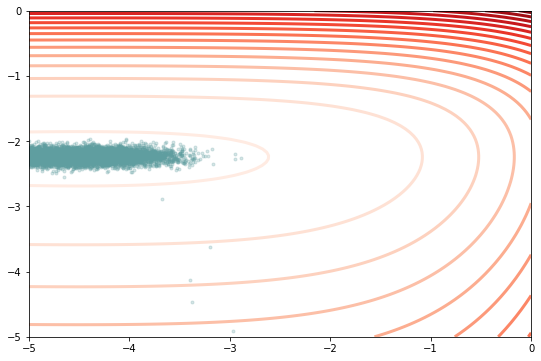

Unknown Parameters:  [-4.02736422 -2.12087218 20.71438595 -6.69245009 -7.60198465  2.41900807
  0.36338428  6.35974332 -0.08195352  2.48507775  0.32447067]


In [33]:
mu = S[-1, 2:]

pred_train = X_train @ mu
pred_test = X_test @ mu

rmse_train = mean_squared_error(y_train, pred_train, squared=False)
rmse_test = mean_squared_error(y_test,pred_test, squared=False)

print('RSME for Training -', rmse_train)
print('RSME for Testing -', rmse_test)

hps = S[-1, :]
log_alpha = np.linspace(-5,0, 100)
log_beta = np.linspace(-5,0, 100)

energy_func = np.empty([100,100])
for row,a in enumerate(log_alpha):
    for col,b in enumerate(log_beta):
        hps[0] = a
        hps[1] = b
        energy_func[col, row] = energy_func_lr(hps, X_train, Y_train)

plt.figure(figsize=(9,6))
plt.contour(log_alpha, log_beta, energy_func, 15, cmap='Reds', linewidths=3, zorder=1)
plt.plot(S[:, 0], S[:, 1], '.', ms=6, alpha=0.25, color='CadetBlue', zorder=0)
plt.xlim(-5,0)
plt.ylim(-5,0)
plt.show()

print('Unknown Parameters: ',np.mean(S, axis = 0))

# Task 6: Gaussian Processes

###  **(3 marks)**

There's no restriction on the GP implementation, you could either use the sklearn package or the Tensorflow style, the latter of which may receive extra bonus mark depending on the quality of implementation.  

You only need to estimate the weights from $x0$ to $x8$ in this task, then calculate RMSE and plot supporting figures for your report. 

<font color=Red>  It is highly recommended that you impelment this part in a seperated file if your implementation contains too many extra libraries, as it may fool the auto-marker and incorrectly mark the rest of your notebook. 
<font>   
    
    


Look to file: gaussian_process.ipynb